In [7]:
import stock_analysis
from stock_analysis.utils import group_stocks
from stock_analysis.utils import make_portfolio
from stock_analysis import StockModeler
import itertools
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import EngFormatter
import pandas as pd
import numpy as np
import avconf

In [10]:
start, end = '2019-01-01', '2020-12-31'
r = stock_analysis.StockReader(start, end)



In [11]:

coin = r.get_bitcoin_data('USD')


fb, aapl, amzn, nflx, goog = (r.get_ticker_data(ticker) for ticker in ['FB', 'AAPL', 'AMZN', 'NFLX', 'GOOG'])


sp = r.get_index_data('S&P 500')

faang = group_stocks({'Facebook': fb, 'Apple': aapl, 'Amazon': amzn, 'Netflix': nflx, 'Google': goog})

RemoteDataError: Unable to read URL: https://finance.yahoo.com/quote/BTC-USD/history?period1=1546336800&period2=1609495199&interval=1d&frequency=1d&filter=history
Response Text:
b'<!DOCTYPE html>\n  <html lang="en-us"><head>\n  <meta http-equiv="content-type" content="text/html; charset=UTF-8">\n      <meta charset="utf-8">\n      <title>Yahoo</title>\n      <meta name="viewport" content="width=device-width,initial-scale=1,minimal-ui">\n      <meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1">\n      <style>\n  html {\n      height: 100%;\n  }\n  body {\n      background: #fafafc url(https://s.yimg.com/nn/img/sad-panda-201402200631.png) 50% 50%;\n      background-size: cover;\n      height: 100%;\n      text-align: center;\n      font: 300 18px "helvetica neue", helvetica, verdana, tahoma, arial, sans-serif;\n  }\n  table {\n      height: 100%;\n      width: 100%;\n      table-layout: fixed;\n      border-collapse: collapse;\n      border-spacing: 0;\n      border: none;\n  }\n  h1 {\n      font-size: 42px;\n      font-weight: 400;\n      color: #400090;\n  }\n  p {\n      color: #1A1A1A;\n  }\n  #message-1 {\n      font-weight: bold;\n      margin: 0;\n  }\n  #message-2 {\n      display: inline-block;\n      *display: inline;\n      zoom: 1;\n      max-width: 17em;\n      _width: 17em;\n  }\n      </style>\n  <script>\n    document.write(\'<img src="//geo.yahoo.com/b?s=1197757129&t=\'+new Date().getTime()+\'&src=aws&err_url=\'+encodeURIComponent(document.URL)+\'&err=%<pssc>&test=\'+encodeURIComponent(\'%<{Bucket}cqh[:200]>\')+\'" width="0px" height="0px"/>\');var beacon = new Image();beacon.src="//bcn.fp.yahoo.com/p?s=1197757129&t="+new Date().getTime()+"&src=aws&err_url="+encodeURIComponent(document.URL)+"&err=%<pssc>&test="+encodeURIComponent(\'%<{Bucket}cqh[:200]>\');\n  </script>\n  </head>\n  <body>\n  <!-- status code : 404 -->\n  <!-- Not Found on Server -->\n  <table>\n  <tbody><tr>\n      <td>\n      <img src="https://s.yimg.com/rz/p/yahoo_frontpage_en-US_s_f_p_205x58_frontpage.png" alt="Yahoo Logo">\n      <h1 style="margin-top:20px;">Will be right back...</h1>\n      <p id="message-1">Thank you for your patience.</p>\n      <p id="message-2">Our engineers are working quickly to resolve the issue.</p>\n      </td>\n  </tr>\n  </tbody></table>\n  </body></html>'

In [ ]:
def levels(analyzer, method):
    return [getattr(analyzer, method)(i) for i in range(1, 4)]

nflx_analyzer = stock_analysis.StockAnalyzer(nflx)
support_levels, resistance_levels = (levels(nflx_analyzer, metric) for metric in ['support', 'resistance'])

nflx_viz = stock_analysis.StockVisualizer(nflx)
ax = nflx_viz.evolution_over_time('close', figsize=(15, 8), title='NFLX Closing Price')

for support, resistance, linestyle, level in zip(support_levels, resistance_levels, [':', '--', '-.'], itertools.count(1)):
    nflx_viz.add_reference_line(ax, y=support, label=f'support level {level}', color='green', linestyle=linestyle)
    nflx_viz.add_reference_line(ax, y=resistance, label=f'resistance level {level}', color='red', linestyle=linestyle)
ax.get_legend().remove()
ax.set_ylabel('price ($)')

In [ ]:
stock_analysis.AssetGroupVisualizer(faang).after_hours_trades()

In [ ]:
stock_analysis.StockVisualizer(make_portfolio(faang)).after_hours_trades()

In [ ]:
ax = stock_analysis.StockVisualizer(make_portfolio(faang)).open_to_close()
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

In [ ]:
def reindex_stock_data(df):
    result = df.copy().reindex(pd.date_range(start, end=end, freq='D')).assign(volume=lambda x: x.fillna(0), close=lambda x: x.fillna(method='ffill'), open=lambda x: x.open.combine_first(x.close), high=lambda x: x.high.combine_first(x.close), low=lambda x: x.low.combine_first(x.close))
    result.index.rename('date', inplace=True)
    return result

sp_reindexed = reindex_stock_data(sp)

ax = stock_analysis.StockVisualizer(bitcoin + sp_reindexed).open_to_close()
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

In [ ]:
fbalx = reader.get_ticker_data('FBALX')
msft = reader.get_ticker_data('MSFT')
mutual_fund = group_stocks({'0 - FDHY': fdhy,'1 - Microsoft': msft, '2 - Apple': aapl, '3 - Amazon': amzn})
stock_analysis.AssetGroupAnalyzer(mutual_fund).analyze('annualized_volatility')

In [ ]:
def metrics(stock, index, r_f):
   
    return pd.DataFrame({metric: getattr(stock_analysis.StockAnalyzer(stock), metric)(**kwargs) \
        for metric, kwargs in {'alpha': {'index': index, 'r_f': r_f}, 'beta': {'index': index}, 'sharpe_ratio': {'r_f': r_f},'annualized_volatility': {}, 'is_bear_market': {}, 'is_bull_market': {}}.items()}, index=range(1))

metrics(fdhy, sp, r_f=reader.get_risk_free_rate_of_return())

In [ ]:
train, test = sp['2019':'2020-11'], sp.loc['2020-12']

arima_model = StockModeler.arima(train, ar=15, i=1, ma=5)

dates = test.index

arima_ax = StockModeler.arima_predictions(train, arima_model, start=dates[0], end=dates[-1], title='ARIMA', color='b', figsize=(15, 3), alpha=0.5)
test.close.plot(ax=arima_ax, style='b--', label='actual close', alpha=0.5)
arima_ax.legend()
arima_ax.set_ylabel('price ($)')
arima_ax.yaxis.set_major_formatter(EngFormatter())

for spine in ['top', 'right']:
    arima_ax.spines[spine].set_visible(False)

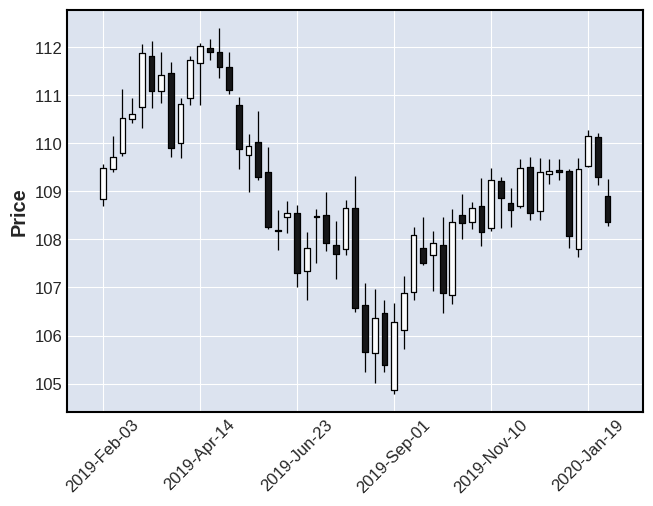

In [9]:
forex = r.get_forex_rates('USD', 'JPY', api_key=avconf.key)

stock_analysis.StockVisualizer(forex).candlestick(date_range=slice('2019-02-01', '2020-01-31'), resample='1W')